In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from multiprocess import Pool

In [12]:
# Fit folder
Architectures = [2, 5, 10, 20]#, 50, 70]
def FitPath(size):
  return "/Users/s2569857/Codes/NTK-interface/Results/240521_GD5_1_" + str(size) + "_" + str(size) + "_1"
FitFolders = [FitPath(size) for size in Architectures]


In [24]:
from abc import ABC, abstractmethod
from functools import partial

_data_sample_size = 4

class Observable(ABC):

    def __init__(self, FitFolder, shape, observable_name, reduced_reps=0):
        self.FitFolder = FitFolder
        number_of_replicas = len(listdir(FitFolder + "/log/"))
        self.shape = shape
        self.observable_name = observable_name
        if reduced_reps > number_of_replicas:
            raise ValueError("The reduced number of replicas should be less than the total number of replicas.")
        elif reduced_reps < number_of_replicas and (reduced_reps != 0):
            self.number_of_replicas = reduced_reps
        else:
            self.number_of_replicas = number_of_replicas
        

        with open(FitFolder + "/meta.yaml", "r") as meta:
            Meta = yaml.load(meta, Loader=yaml.CLoader)

        Meta["data_sample_size"] = _data_sample_size

        self.size_of_data = Meta["data_sample_size"]
        self.size_of_output = Meta['NNarchitecture'][-1]
        self.size_of_NN = Meta["NNarchitecture"][1]

    def load_observable(self, replica, tr_step):
        with open(self.FitFolder + "/log/replica_" + str(replica) + ".yaml", "r") as rep:
            Rep = yaml.load(rep, Loader=yaml.CLoader)
        out = np.ndarray(shape=self.shape, dtype=float, order = 'C', buffer=np.array(Rep[tr_step][self.observable_name]))
        return out
    
    def evaluate(self, replica, tr_step):
        return self.load_observable(replica, tr_step)
        
    def average_over_replicas(self, tr_step):
        shape = self.shape
        obs = np.zeros(shape, dtype=float)

        def eval(i):
            return self.evaluate(i, tr_step)

        pool = Pool(processes=8)
        observable_by_replica = pool.map(eval, range(1,self.number_of_replicas+1))
        #observable_by_replica=[self.evaluate(frep, tr_step) for frep in range(1, self.number_of_replicas)]
        obs = np.average(observable_by_replica, axis = 0)
        std = np.std(observable_by_replica, axis = 0)
        return obs, std

    def average_over_replicas_test(self, tr_step):
        shape = self.shape
        obs = np.zeros(shape, dtype=float)
        def eval(i):
            return self.evaluate(i, tr_step)
        pool = Pool(processes=8)
        if self.number_of_replicas > 1000:
            chsize = 1000
        else:
            chsize = 100
        results = pool.imap_unordered(eval, range(1,self.number_of_replicas+1),  chunksize=chsize)
        observable_by_replica = [item for item in results]
        obs = np.average(observable_by_replica, axis = 0)
        std = np.std(observable_by_replica, axis = 0)
        return obs, std

In [25]:
class NTK_element_wise(Observable):
    def __init__ (self, FitFolder, shape, observable_name,reduced_reps=0):
        super().__init__(FitFolder, shape, observable_name,reduced_reps)

class NTK_frob(Observable):
    def __init__ (self, FitFolder, shape, observable_name,reduced_reps=0):
        super().__init__(FitFolder, shape, observable_name,reduced_reps)
    
    def evaluate(self, replica, tr_step):
        return np.linalg.norm(self.load_observable(replica, tr_step))
    
class O3(Observable):
    def __init__ (self, FitFolder, shape, observable_name,reduced_reps=0):
        super().__init__(FitFolder, shape, observable_name,reduced_reps)

    def evaluate(self, replica, tr_step):
        return np.linalg.norm(self.load_observable(replica, tr_step))    

## Loop over FitFolders and plot a grapgh as function of the size of the network
The plots are generated at initialisation

In [21]:
labels = np.zeros(len(FitFolders))
ntk_mean_values = np.zeros(len(FitFolders))
ntk_std_values = np.zeros(len(FitFolders))
ntk_full_mean_values = np.zeros(len(FitFolders))
ntk_full_std_values = np.zeros(len(FitFolders))
O3_mean_values = np.zeros(len(FitFolders))
O3_std_values = np.zeros(len(FitFolders))

for i, fit in enumerate(FitFolders):
    
    # TO_DO
    # _data_sample_size is hardcoded and not really recommended. Try to
    # to make it more general
    ntk_frob = NTK_frob(fit, shape=(_data_sample_size, _data_sample_size), observable_name="NTK_eigen")
    o3 = O3(fit, shape=(_data_sample_size, _data_sample_size, _data_sample_size), observable_name="O_3")
    ntk = NTK_element_wise(fit, shape=(_data_sample_size, _data_sample_size), observable_name="NTK_eigen")

    ntk_frob_mean, ntk_frob_std = ntk_frob.average_over_replicas_test(0)
    o3_mean, o3_std = o3.average_over_replicas_test(0)
    ntk_full_mean, ntk_full_std = ntk.average_over_replicas_test(0)

    ntk_full_mean_values[i] = np.linalg.norm(ntk_full_mean)
    ntk_full_std_values[i] = np.linalg.norm(ntk_full_std)
    ntk_mean_values[i] = ntk_frob_mean
    ntk_std_values[i] = ntk_frob_std
    O3_mean_values[i] = o3_mean
    O3_std_values[i] = o3_std
    labels[i] = Architectures[i]

617823
1000
1000
1000


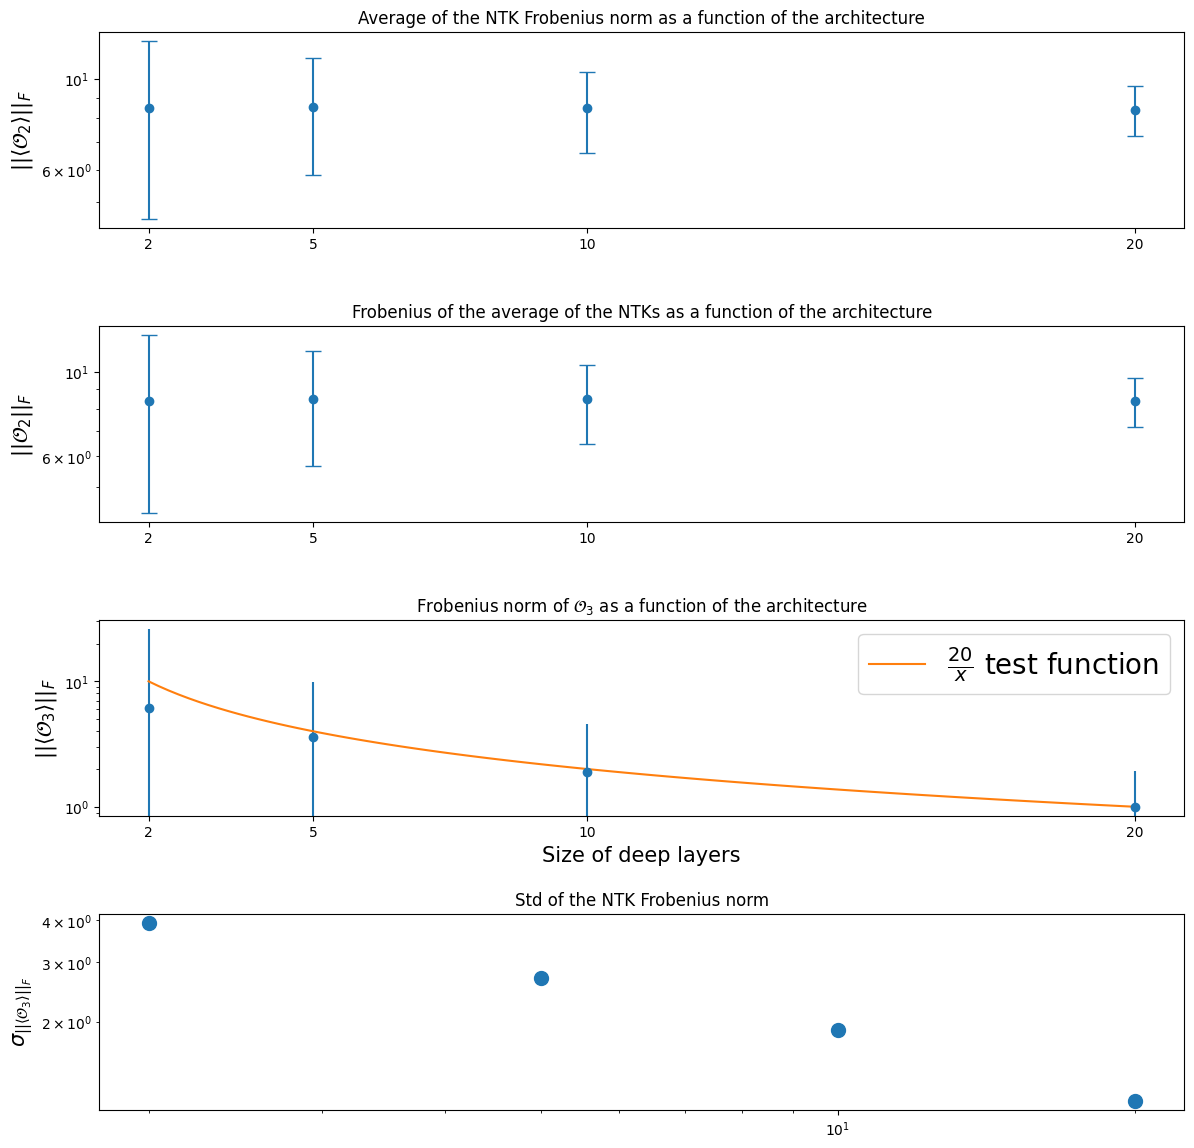

In [23]:
from matplotlib.ticker import MaxNLocator

f, ax = plt.subplots(4,1, sharex=False, gridspec_kw = {"hspace" : 0.5}, figsize=(14,14))
#ax.plot( NTK_frob_norms, 'bo', )
ax[0].errorbar(labels, ntk_mean_values, yerr = ntk_std_values, fmt='o', capsize=6)
ax[0].set_ylabel(r"$||\left<\mathcal{O}_2 \right>||_F$", fontsize=15)
ax[0].set_title("Average of the NTK Frobenius norm as a function of the architecture")
ax[0].set_xticks(labels)
ax[0].set_yscale('log')
ax[0].set_yscale('log')

ax[1].errorbar(labels, ntk_full_mean_values, yerr = ntk_full_std_values, fmt='o', capsize=6)
ax[1].set_ylabel(r"$||\mathcal{O}_2 ||_F$", fontsize=15)
ax[1].set_title("Frobenius of the average of the NTKs as a function of the architecture")
ax[1].set_xticks(labels)
ax[1].set_yscale('log')
ax[1].set_yscale('log')

ax[2].errorbar(labels, O3_mean_values, yerr = O3_std_values, fmt='o')
ax[2].set_title("Frobenius norm of $\mathcal{O}_3$ as a function of the architecture")
ax[2].set_xlabel(r"Size of deep layers", fontsize=15)
ax[2].set_ylabel(r"$|| \left< \mathcal{O}_3 \right> ||_F$", fontsize=15)
ax[2].plot(np.linspace(2,20,100), [20/x for x in np.linspace(2,20,100)], label=r"$\frac{20}{x}$ test function")
ax[2].legend(fontsize=20)
ax[2].set_xticks(labels)
ax[2].set_yscale('log')

ax[3].set_title("Std of the NTK Frobenius norm")
ax[3].set_ylabel(r"$ \sigma_{|| \left< \mathcal{O}_3 \right> ||_F}$", fontsize=15)
ax[3].plot(labels, ntk_std_values, linestyle='', marker='.', markersize=20)
ax[3].set_xticks(labels)
ax[3].set_xscale('log')
ax[3].set_yscale('log')


plt.show()

In [26]:
labels = np.zeros(len(FitFolders))
ntk_mean_values = np.zeros(len(FitFolders))
ntk_std_values = np.zeros(len(FitFolders))
ntk_full_mean_values = np.zeros(len(FitFolders))
ntk_full_std_values = np.zeros(len(FitFolders))
O3_mean_values = np.zeros(len(FitFolders))
O3_std_values = np.zeros(len(FitFolders))

for i, fit in enumerate(FitFolders):
    
    # TO_DO
    # _data_sample_size is hardcoded and not really recommended. Try to
    # to make it more general
    reduced=0
    if (i==0):
      reduced = 1000

    ntk_frob = NTK_frob(fit, shape=(_data_sample_size, _data_sample_size), observable_name="NTK_eigen",reduced_reps=reduced)
    o3 = O3(fit, shape=(_data_sample_size, _data_sample_size, _data_sample_size), observable_name="O_3",reduced_reps=reduced)
    ntk = NTK_element_wise(fit, shape=(_data_sample_size, _data_sample_size), observable_name="NTK_eigen",reduced_reps=reduced)

    ntk_frob_mean, ntk_frob_std = ntk_frob.average_over_replicas_test(0)
    o3_mean, o3_std = o3.average_over_replicas_test(0)
    ntk_full_mean, ntk_full_std = ntk.average_over_replicas_test(0)

    ntk_full_mean_values[i] = np.linalg.norm(ntk_full_mean)
    ntk_full_std_values[i] = np.linalg.norm(ntk_full_std)
    ntk_mean_values[i] = ntk_frob_mean
    ntk_std_values[i] = ntk_frob_std
    O3_mean_values[i] = o3_mean
    O3_std_values[i] = o3_std
    labels[i] = Architectures[i]

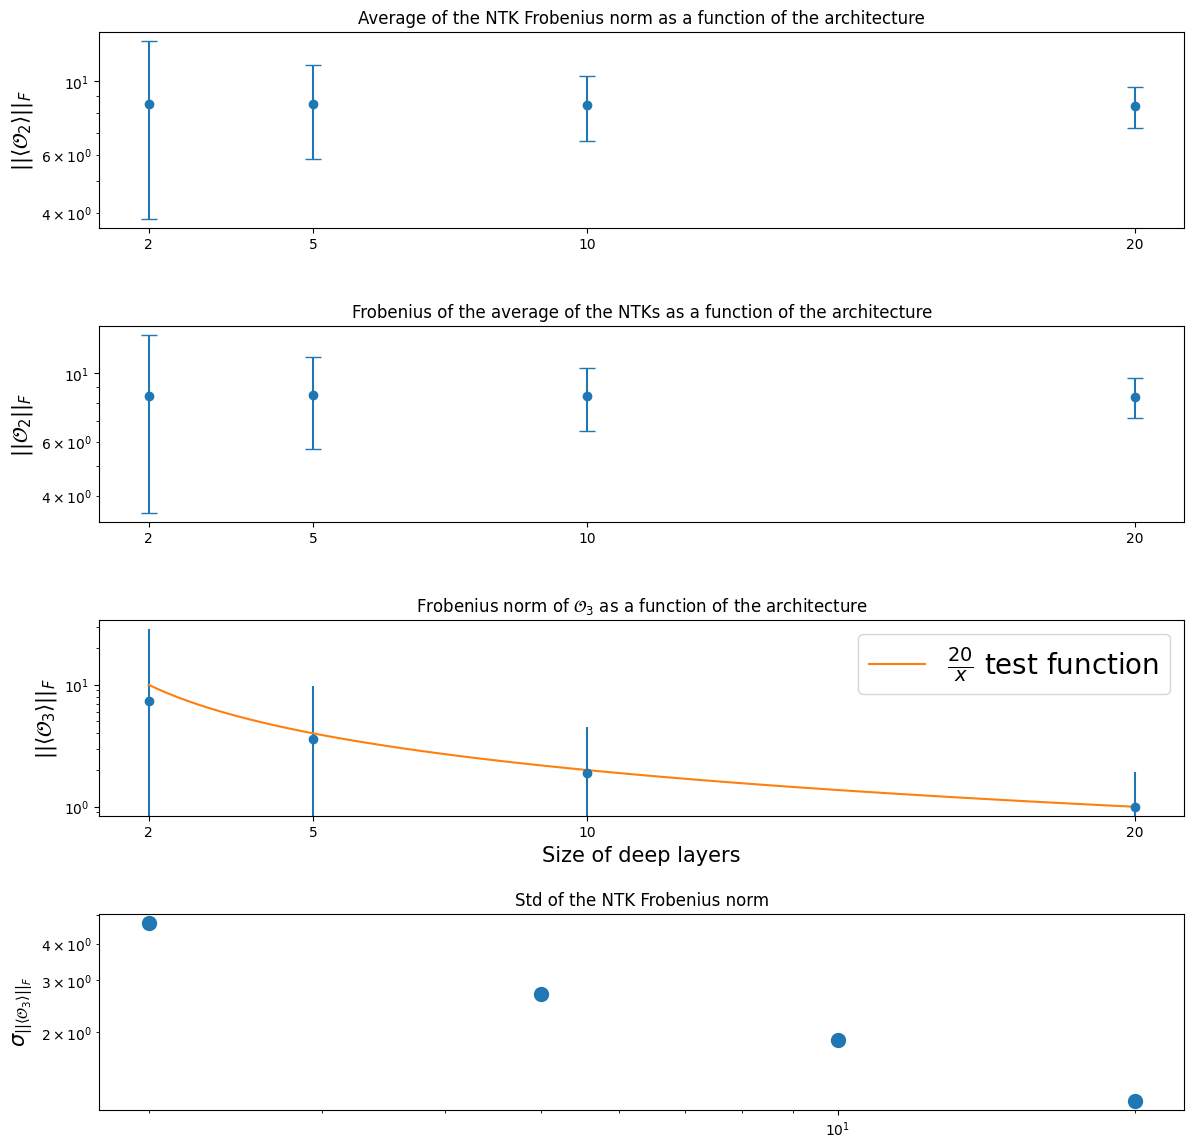

In [27]:
from matplotlib.ticker import MaxNLocator

f, ax = plt.subplots(4,1, sharex=False, gridspec_kw = {"hspace" : 0.5}, figsize=(14,14))
#ax.plot( NTK_frob_norms, 'bo', )
ax[0].errorbar(labels, ntk_mean_values, yerr = ntk_std_values, fmt='o', capsize=6)
ax[0].set_ylabel(r"$||\left<\mathcal{O}_2 \right>||_F$", fontsize=15)
ax[0].set_title("Average of the NTK Frobenius norm as a function of the architecture")
ax[0].set_xticks(labels)
ax[0].set_yscale('log')
ax[0].set_yscale('log')

ax[1].errorbar(labels, ntk_full_mean_values, yerr = ntk_full_std_values, fmt='o', capsize=6)
ax[1].set_ylabel(r"$||\mathcal{O}_2 ||_F$", fontsize=15)
ax[1].set_title("Frobenius of the average of the NTKs as a function of the architecture")
ax[1].set_xticks(labels)
ax[1].set_yscale('log')
ax[1].set_yscale('log')

ax[2].errorbar(labels, O3_mean_values, yerr = O3_std_values, fmt='o')
ax[2].set_title("Frobenius norm of $\mathcal{O}_3$ as a function of the architecture")
ax[2].set_xlabel(r"Size of deep layers", fontsize=15)
ax[2].set_ylabel(r"$|| \left< \mathcal{O}_3 \right> ||_F$", fontsize=15)
ax[2].plot(np.linspace(2,20,100), [20/x for x in np.linspace(2,20,100)], label=r"$\frac{20}{x}$ test function")
ax[2].legend(fontsize=20)
ax[2].set_xticks(labels)
ax[2].set_yscale('log')

ax[3].set_title("Std of the NTK Frobenius norm")
ax[3].set_ylabel(r"$ \sigma_{|| \left< \mathcal{O}_3 \right> ||_F}$", fontsize=15)
ax[3].plot(labels, ntk_std_values, linestyle='', marker='.', markersize=20)
ax[3].set_xticks(labels)
ax[3].set_xscale('log')
ax[3].set_yscale('log')


plt.show()